In [2]:
import sys, os, importlib, numpy as np, pandas as pd
sys.path.append(os.path.abspath(".."))

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

from src import data as data_mod, features as features_mod, utils as utils_mod
importlib.reload(data_mod); importlib.reload(features_mod); importlib.reload(utils_mod)
from src.data import get_data
from src.features import add_features
from src.utils import make_labels


In [3]:
# Use ±0.1% dead-zone to ignore micro moves
df = get_data("AAPL", start="2015-01-01", end="2023-12-31")
df = add_features(df)
df = make_labels(df, tau=0.001, dead_zone=True)  # 0.1% threshold

feat_cols = [c for c in df.columns if c not in ["date","open","high","low","close","volume","ret_next","y"]]
print("Using features:", feat_cols)
X = df[feat_cols].values
y = df["y"].astype(int).values
dates = df["date"].values
len(df), len(feat_cols)


Using features: ['ret1', 'ret5', 'ret10', 'vol10', 'volz', 'rsi14', 'macd', 'macd_signal']


(2078, 8)

In [4]:
n = len(df)
i_tr = int(0.70*n); i_va = int(0.85*n)

X_tr, y_tr = X[:i_tr], y[:i_tr]
X_va, y_va = X[i_tr:i_va], y[i_tr:i_va]
X_te, y_te = X[i_va:], y[i_va:]

scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)
X_tr.shape, X_va.shape, X_te.shape

((1454, 8), (312, 8), (312, 8))

In [5]:
clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(X_tr, y_tr)

p_va = clf.predict_proba(X_va)[:,1]
p_te = clf.predict_proba(X_te)[:,1]

pred_va = (p_va>0.5).astype(int)
pred_te = (p_te>0.5).astype(int)

print("VAL ROC-AUC:", roc_auc_score(y_va, p_va))
print("VAL BalAcc :", balanced_accuracy_score(y_va, pred_va))
print("VAL F1     :", f1_score(y_va, pred_va))
print(confusion_matrix(y_va, pred_va))
print(classification_report(y_va, pred_va, digits=3))

print("\nTEST ROC-AUC:", roc_auc_score(y_te, p_te))
print("TEST BalAcc :", balanced_accuracy_score(y_te, pred_te))
print("TEST F1     :", f1_score(y_te, pred_te))
print(confusion_matrix(y_te, pred_te))
print(classification_report(y_te, pred_te, digits=3))

VAL ROC-AUC: 0.48589780541030186
VAL BalAcc : 0.5057026392720385
VAL F1     : 0.5246913580246914
[[73 76]
 [78 85]]
              precision    recall  f1-score   support

           0      0.483     0.490     0.487       149
           1      0.528     0.521     0.525       163

    accuracy                          0.506       312
   macro avg      0.506     0.506     0.506       312
weighted avg      0.507     0.506     0.507       312


TEST ROC-AUC: 0.474086310138344
TEST BalAcc : 0.48988230435680363
TEST F1     : 0.5107692307692308
[[70 75]
 [84 83]]
              precision    recall  f1-score   support

           0      0.455     0.483     0.468       145
           1      0.525     0.497     0.511       167

    accuracy                          0.490       312
   macro avg      0.490     0.490     0.489       312
weighted avg      0.492     0.490     0.491       312



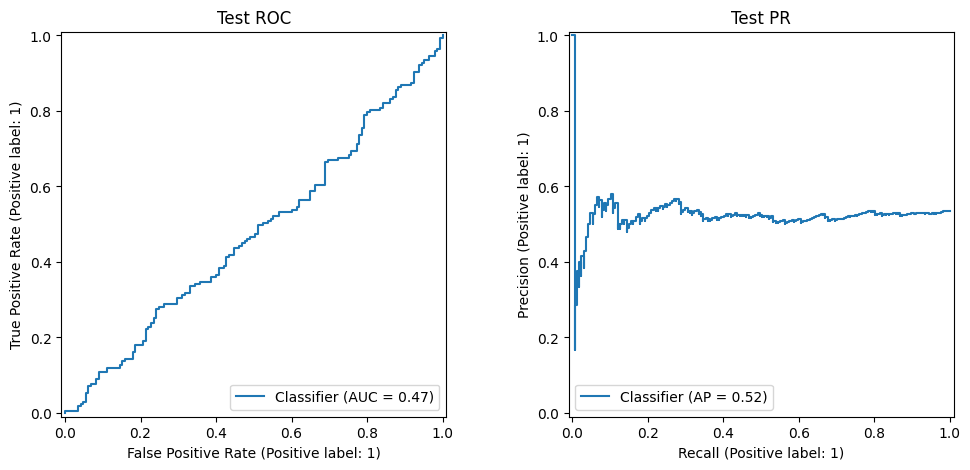

In [6]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1); RocCurveDisplay.from_predictions(y_te, p_te, ax=ax1); ax1.set_title("Test ROC")
ax2 = plt.subplot(1,2,2); PrecisionRecallDisplay.from_predictions(y_te, p_te, ax=ax2); ax2.set_title("Test PR")
plt.show()


Strategy Sharpe (ann.): -0.2645514542885317
Buy&Hold Sharpe (ann.): 0.7400393955679089
Strategy MaxDD: -0.07890908696026211
Buy&Hold MaxDD: -0.23393569951879967


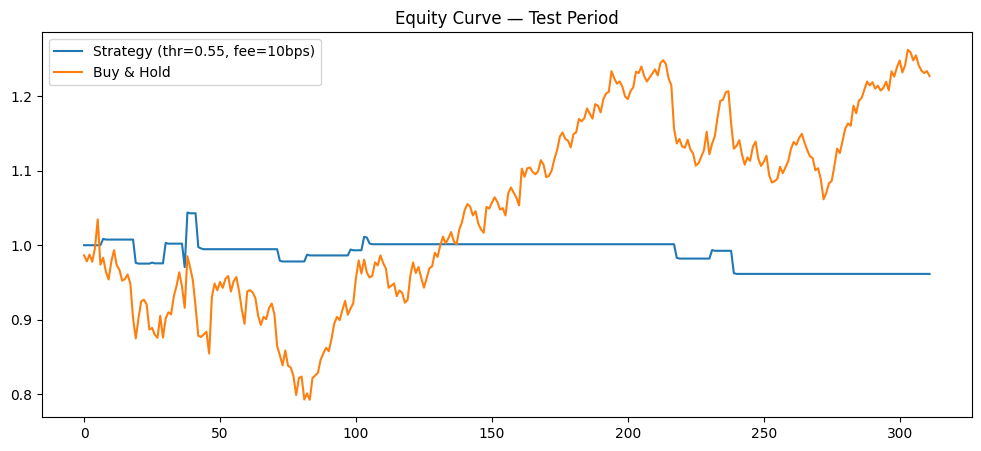

In [7]:
thr = 0.55     # confidence threshold
fee = 0.0010   # 10 bps per trade

test_df = df.iloc[int(0.85*len(df)):].copy().reset_index(drop=True)
test_df["p"] = p_te

pos = (test_df["p"].values > thr).astype(int)   # long-only when confident
r = test_df["ret_next"].values                  # next-day return

trades = np.abs(np.diff(np.r_[0, pos]))         # position changes
costs = trades * fee

strat_r = pos * r - costs
bh_r    = r

def equity_curve(returns): return (1 + pd.Series(returns)).cumprod()
def sharpe(returns):
    s = np.std(returns); 
    return 0.0 if s==0 else np.mean(returns)/s*np.sqrt(252)
def max_drawdown(series):
    peak = series.cummax()
    dd = series/peak - 1.0
    return dd.min()

eq_strat = equity_curve(strat_r)
eq_bh    = equity_curve(bh_r)

print("Strategy Sharpe (ann.):", sharpe(strat_r))
print("Buy&Hold Sharpe (ann.):", sharpe(bh_r))
print("Strategy MaxDD:", max_drawdown(eq_strat))
print("Buy&Hold MaxDD:", max_drawdown(eq_bh))

plt.figure(figsize=(12,5))
plt.plot(eq_strat.values, label=f"Strategy (thr={thr:.2f}, fee={int(fee*1e4)}bps)")
plt.plot(eq_bh.values,    label="Buy & Hold")
plt.title("Equity Curve — Test Period")
plt.legend(); plt.show()


Coverage (in-position days): 5.13%
Trades: 28


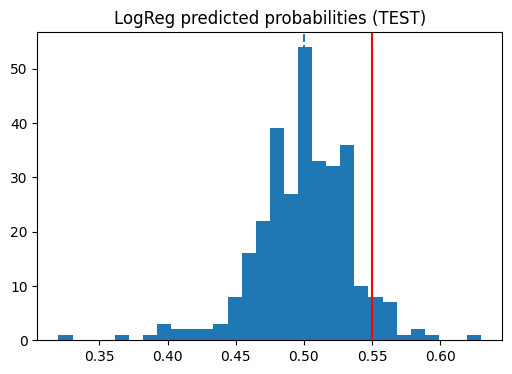

In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

if 'test_df' not in globals() or 'p_logreg' not in getattr(test_df, 'columns', []):
    test_df = df.iloc[int(0.85*len(df)):].copy().reset_index(drop=True)
    test_df["p_logreg"] = p_te[:len(test_df)]

probs = test_df["p_logreg"].values

coverage = (probs > thr).mean()
trades_count = int(np.abs(np.diff(np.r_[0, (probs > thr).astype(int)])).sum())
print(f"Coverage (in-position days): {coverage:.2%}")
print("Trades:", trades_count)

plt.figure(figsize=(6,4))
plt.hist(probs, bins=30)
plt.axvline(0.5, ls="--"); plt.axvline(thr, color="r")
plt.title("LogReg predicted probabilities (TEST)")
plt.show()


In [9]:
def sharpe_daily(r):
    r = pd.Series(r); s = r.std()
    return 0.0 if s == 0 else r.mean()/s*np.sqrt(252)

def strat_sharpe_from_probs(p, ret_next, fee=0.0010, thr=0.55):
    pos = (p > thr).astype(int)
    trades = np.abs(np.diff(np.r_[0, pos])) * fee
    strat_r = pos * ret_next - trades
    return sharpe_daily(strat_r)

val_slice = slice(int(0.70*len(df)), int(0.85*len(df)))
val_ret_next = df.iloc[val_slice]["ret_next"].values

grid = np.linspace(0.50, 0.60, 21)
thr_log = max(grid, key=lambda t: strat_sharpe_from_probs(p_va, val_ret_next, fee=0.0010, thr=t))
thr_log


np.float64(0.6)

LogReg Strategy Sharpe (tuned): 0.7892759919444253
Buy&Hold Sharpe               : 0.7400393955679089
LogReg MaxDD (tuned): -0.001000000000000112 | BH MaxDD: -0.23393569951879967


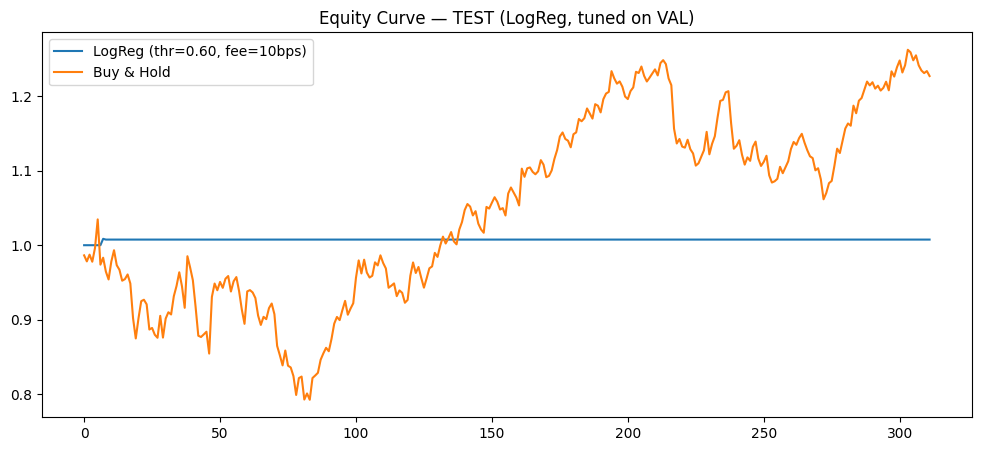

In [10]:
thr = float(thr_log)

pos = (test_df["p_logreg"].values > thr).astype(int)
trades = np.abs(np.diff(np.r_[0, pos])); costs = trades * fee
strat_r = pos * r - costs
eq_s, eq_b = (1+pd.Series(strat_r)).cumprod(), (1+pd.Series(r)).cumprod()

print("LogReg Strategy Sharpe (tuned):", sharpe(strat_r))
print("Buy&Hold Sharpe               :", sharpe(bh_r))
print("LogReg MaxDD (tuned):", max_drawdown(eq_s), "| BH MaxDD:", max_drawdown(eq_b))

plt.figure(figsize=(12,5))
plt.plot(eq_s.values, label=f"LogReg (thr={thr:.2f}, fee=10bps)")
plt.plot(eq_b.values, label="Buy & Hold")
plt.title("Equity Curve — TEST (LogReg, tuned on VAL)")
plt.legend(); plt.show()


In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=42, n_jobs=-1
)
xgb.fit(X_tr, y_tr)

p_va_xgb = xgb.predict_proba(X_va)[:, 1]
p_te_xgb = xgb.predict_proba(X_te)[:, 1]

print("VAL AUC (XGB):", roc_auc_score(y_va, p_va_xgb))
print("TEST AUC (XGB):", roc_auc_score(y_te, p_te_xgb))


VAL AUC (XGB): 0.5425124552229588
TEST AUC (XGB): 0.46107784431137727


In [12]:
val_ret_next = df.iloc[val_slice]["ret_next"].values  # already defined slice
grid = np.linspace(0.50, 0.60, 21)
thr_xgb = max(grid, key=lambda t: strat_sharpe_from_probs(p_va_xgb, val_ret_next, fee=0.0010, thr=t))
thr_xgb


np.float64(0.58)

XGB Strategy Sharpe: -0.8175341461425385
Buy&Hold Sharpe   : 0.7400393955679089
XGB MaxDD: -0.1827431216535863 | BH MaxDD: -0.23393569951879967


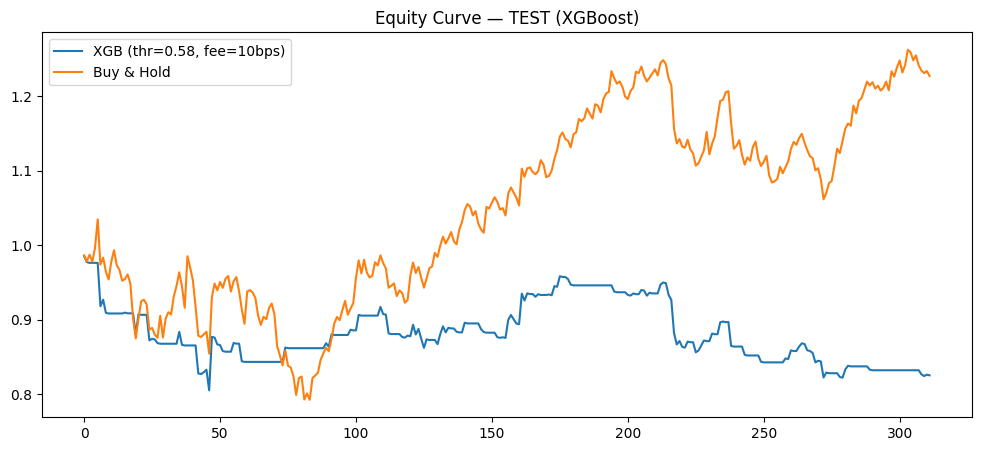

In [13]:
fee = 0.0010

test_df_xgb = df.iloc[int(0.85*len(df)):].copy().reset_index(drop=True)
test_df_xgb["p_xgb"] = p_te_xgb
r_x = test_df_xgb["ret_next"].values

pos_x = (test_df_xgb["p_xgb"].values > thr_xgb).astype(int)
trades_x = np.abs(np.diff(np.r_[0, pos_x])); costs_x = trades_x * fee
strat_r_x = pos_x * r_x - costs_x
bh_r_x = r_x

eq_s_x, eq_b_x = (1+pd.Series(strat_r_x)).cumprod(), (1+pd.Series(bh_r_x)).cumprod()

print("XGB Strategy Sharpe:", sharpe(strat_r_x))
print("Buy&Hold Sharpe   :", sharpe(bh_r_x))
print("XGB MaxDD:", max_drawdown(eq_s_x), "| BH MaxDD:", max_drawdown(eq_b_x))

plt.figure(figsize=(12,5))
plt.plot(eq_s_x.values, label=f"XGB (thr={thr_xgb:.2f}, fee=10bps)")
plt.plot(eq_b_x.values, label="Buy & Hold")
plt.title("Equity Curve — TEST (XGBoost)")
plt.legend(); plt.show()


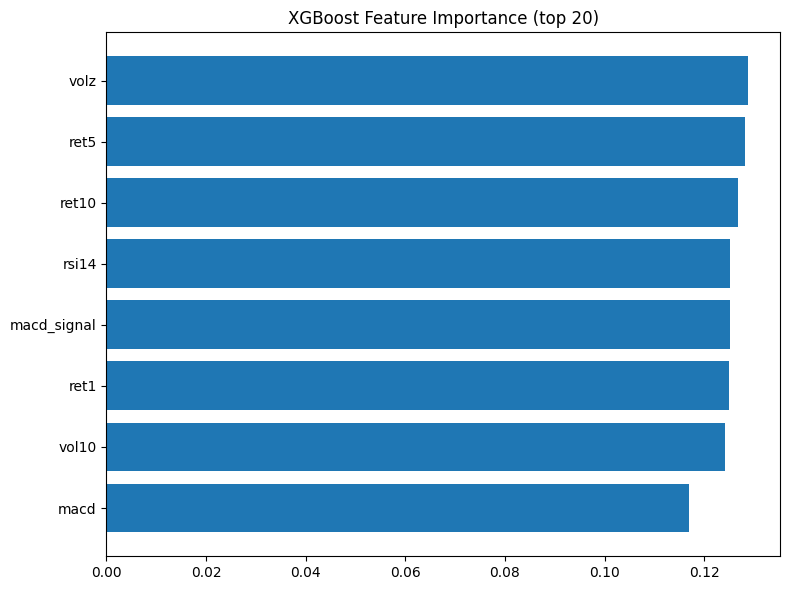

In [14]:
imp = xgb.feature_importances_
order = np.argsort(imp)[::-1][:20]
plt.figure(figsize=(8,6))
plt.barh(np.array(feat_cols)[order][::-1], imp[order][::-1])
plt.title("XGBoost Feature Importance (top 20)")
plt.tight_layout(); plt.show()
